# <p style="text-align: center;">Housing Market Predictor</p> 

**Start Date:** 2024-03-18  
**Authors:**  *Laura Cornejo Paulino * and *Shreyas Chitransh* 

## Introduciton
--------------------------------------------------------------------------------------------------------------------------------------------
In this project we explore historical housing data and construct predictive modeling to predict housing prices with the hopes of capturing the decline in the current (2024) housing market. 

The data can be found in the following [location](https://drive.google.com/file/d/1sNm33rOHkcqPwb1QA_JnLT2VFlOlnPW7/view?usp=drive_link).


Once the data is in the appropriate directory we can conduct a big picture exploration of our data. Let's start by loading a few of the important libraries and then look at our data.


In [1]:
# Import relevant libraries

import numpy as np                      # Working with arrays 
import pandas as pd                     # Working with Datasets
from matplotlib import pyplot as plt    # Creating plots and viewing images


Let's start by loading the data with Pandas.

In [2]:
raw_df = pd.read_csv("data/Real_Estate_Sales_2001-2021_GL.csv", low_memory=False)

We can have a look at the data using `.head()` to see the first few rows and guage any insights. 

In [3]:
raw_df.head()

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Non Use Code,Assessor Remarks,OPM remarks,Location
0,2020348,2020,09/13/2021,Ansonia,230 WAKELEE AVE,150500.0,325000.0,0.4630,Commercial,NaN,NaN,NaN,NaN,NaN
1,20002,2020,10/02/2020,Ashford,390 TURNPIKE RD,253000.0,430000.0,0.5883,Residential,Single Family,NaN,NaN,NaN,NaN
2,210317,2021,07/05/2022,Avon,53 COTSWOLD WAY,329730.0,805000.0,0.4096,Residential,Single Family,NaN,NaN,NaN,POINT (-72.846365959 41.781677018)
3,200212,2020,03/09/2021,Avon,5 CHESTNUT DRIVE,130400.0,179900.0,0.7248,Residential,Condo,NaN,NaN,NaN,NaN
4,200243,2020,04/13/2021,Avon,111 NORTHINGTON DRIVE,619290.0,890000.0,0.6958,Residential,Single Family,NaN,NaN,NaN,NaN


There seem to be specific columns related to:
- `Serial Number` (Should be numerical)
- `List Year` (May be redundant as we have a Date column)
- `Date Recorded` that the listing was recorded (Need to check if it's datetime)
- `Town` of the listing (Categorical)
- `Address` of the listing (String)
- `Assessed Value` of the listing (Float in USD)
- `Sale Amount` (Need to check whether it is integer, but should be numerical overall)
- `Sales Ratio` (Float of assesed value divided by Sale amount)
- `Property Type` (Categorical String)
- `Residential Type` (Categorical)
- `Non Use Code`  Unsure what the column contains but it has a lot of NaNs
- `Assesor Remark` Contains a lot of NaNs and likely string of comments by Assesor
- `OPM Remark` Contains a lot of NaN's and likely string of comments by OPM (Find out what OPM is)
- `Location` contains some latitude and longitude data but also a lot of NaNs

Below we can confirm whether the expected data types match or whether they need to be reset using `.info()` which can give data types, index listings and missing indices in columns. 

In [4]:
# Use .info()
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1054159 entries, 0 to 1054158
Data columns (total 14 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Serial Number     1054159 non-null  int64  
 1   List Year         1054159 non-null  int64  
 2   Date Recorded     1054157 non-null  object 
 3   Town              1054159 non-null  object 
 4   Address           1054108 non-null  object 
 5   Assessed Value    1054159 non-null  float64
 6   Sale Amount       1054159 non-null  float64
 7   Sales Ratio       1054159 non-null  float64
 8   Property Type     671713 non-null   object 
 9   Residential Type  660275 non-null   object 
 10  Non Use Code      302242 non-null   object 
 11  Assessor Remarks  161472 non-null   object 
 12  OPM remarks       11564 non-null    object 
 13  Location          254643 non-null   object 
dtypes: float64(3), int64(2), object(9)
memory usage: 112.6+ MB


## Data Cleaning
--------------------------------------------------------------------------------------------------------------------------------------------
We can explore the missing information that needs to be imputed and/or dropped based on the data. 

- The index seems to be correct and there are 1.054 Million rows of data with 14 columns.
- The first 8 columns all seem to have almost all of the data recorded. However we need to ensure that there are no codes or categories in there which relate to `unknown` which is still considered missing information. 
- The `Date Recorded` needs to be converted to datetime datatype. 
- A lot of data is missing in:
    - `Property Type`;
    - `Residential Type`; 
    - `Non Use Code`;
    - `Assesor Remark`; 
    - `OPM Remark`;
    - `Location`.

We can check the total number of rows missing for the columns and the exact percentage below that.


In [5]:
# Look at all of the rows with null vales and sum them columnwise
raw_df.isna().sum()

Serial Number             0
List Year                 0
Date Recorded             2
Town                      0
Address                  51
Assessed Value            0
Sale Amount               0
Sales Ratio               0
Property Type        382446
Residential Type     393884
Non Use Code         751917
Assessor Remarks     892687
OPM remarks         1042595
Location             799516
dtype: int64

In [6]:
# Divide the sum of total null values by the total number of rows to get percentage of null values
raw_df.isna().sum()/raw_df.shape[0]*100

Serial Number        0.000000
List Year            0.000000
Date Recorded        0.000190
Town                 0.000000
Address              0.004838
Assessed Value       0.000000
Sale Amount          0.000000
Sales Ratio          0.000000
Property Type       36.279726
Residential Type    37.364762
Non Use Code        71.328614
Assessor Remarks    84.682387
OPM remarks         98.903012
Location            75.843967
dtype: float64

There are 2 rows of `Date Recorded` missing which is good, as this is a time series problem and we will eventually be turning the Dates into an index after resampling them.   

There are 51 addresses missing which we will attempt to impute using other columns if we can.   

`Property Type` and `Residential Type` are bothing missing 36-37% of data and we can check whether the same rows are missing both the pieces of data.  

`Non Use Code`, `Assessor Remarks`, `OPM Remarks` and `Location` are all missing over 70% of the data. 

We will likely not be using these columns anyway (unless we want a non time-series based analysis). Therefore, for now we can drop these columns. 

In [7]:
# Drop the discussed columns, inplace so the dataframe doesn't need to be overwritten  
# and axis=1 is referring to columns
raw_df.drop(['Non Use Code', 'Assessor Remarks', 'OPM remarks', 'Location'], inplace=True, axis=1)

We can conduct a sanity check below to ensure that the columns indeed got dropped. 

In [8]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1054159 entries, 0 to 1054158
Data columns (total 10 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Serial Number     1054159 non-null  int64  
 1   List Year         1054159 non-null  int64  
 2   Date Recorded     1054157 non-null  object 
 3   Town              1054159 non-null  object 
 4   Address           1054108 non-null  object 
 5   Assessed Value    1054159 non-null  float64
 6   Sale Amount       1054159 non-null  float64
 7   Sales Ratio       1054159 non-null  float64
 8   Property Type     671713 non-null   object 
 9   Residential Type  660275 non-null   object 
dtypes: float64(3), int64(2), object(5)
memory usage: 80.4+ MB


Now that we are sure that the columns got dropped, we can go ahead and optimise the dataset more to our workflow. As a first step we will standardise the column names to include underscore instead of space to make it easier for coding. We will also be converting all the column names to lower case for the same reason. Note that this is a personal choice and not standardised practice. 

In [9]:
# Create a for loop to iterate over all of the columns by calling all the columns from the raw_df
for column in raw_df.columns:

    # Store a version of the original column name for later use
    original_column = column

    # For the column name, lower te case and replace space with underscore
    column = column.lower().replace(" ", "_")

    # Replace the dataframe by renaming the columns by taking original column name saved
    # and replacing it with the updated column
    raw_df = raw_df.rename(columns={original_column:column})


Let's confirm the renaming worked for the columns. 

In [10]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1054159 entries, 0 to 1054158
Data columns (total 10 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   serial_number     1054159 non-null  int64  
 1   list_year         1054159 non-null  int64  
 2   date_recorded     1054157 non-null  object 
 3   town              1054159 non-null  object 
 4   address           1054108 non-null  object 
 5   assessed_value    1054159 non-null  float64
 6   sale_amount       1054159 non-null  float64
 7   sales_ratio       1054159 non-null  float64
 8   property_type     671713 non-null   object 
 9   residential_type  660275 non-null   object 
dtypes: float64(3), int64(2), object(5)
memory usage: 80.4+ MB


Now that the column names are replaced, we can start by checking some of the distributions that can assist us with better understanding the data and may even helo us with imputing missing data. Accordingly we will start with visualising the rows where `address` is missing. We will start by looking at the first 10 rows of data where `address` is missing.

In [11]:
raw_df[raw_df['address'].isna()].head(50)

,serial_number,list_year,date_recorded,town,address,assessed_value,sale_amount,sales_ratio,property_type,residential_type
75944,39999,2003,02/02/2004,West Haven,NaN,0.0,0.0,0.000000,NaN,NaN
89004,49996,2004,05/17/2005,Lisbon,NaN,0.0,0.0,0.000000,NaN,NaN
101602,48886,2004,06/13/2005,Lisbon,NaN,0.0,0.0,0.000000,NaN,NaN
145969,10537,2001,02/05/2002,Hartford,NaN,0.0,120000.0,0.000000,NaN,NaN
149638,10640,2001,12/19/2001,Bridgeport,NaN,2106020.0,45000.0,46.800444,NaN,NaN
234863,20280,2002,NaN,Orange,NaN,0.0,0.0,0.000000,NaN,NaN
236356,0,2002,NaN,Orange,NaN,0.0,0.0,0.000000,NaN,NaN
263008,30125,2003,11/10/2003,New Milford,NaN,55090.0,400000.0,0.137725,NaN,NaN
276118,39998,2003,08/12/2004,Lisbon,NaN,0.0,0.0,0.000000,NaN,NaN
284788,30100,2003,05/20/2004,North Stonington,NaN,7210.0,149000.0,0.048389,NaN,NaN


This has provided a lot of interesting insights immedietely. 
1. The 2 rows of missing `date_recorded` are also coinciding with missing address. 
2. There are a lot of listings where the `assessed_value` and/or `sale_amount` (and therefore `sales_ratio`) are 0. This is important to note as these values would be used in our data for the time series modeling.
3. The dates of these listings with missing addresses are mostly quite old, around 2004-2007 which works better for our modeling as we will then have cleaner data for dates nearer to our target years of early 2020's.

We can actually drop the address column too as it won't be used for the time series analysis, but as part of this workflow, we can also create a cleaner overall dataset that can potentially be used for other modelling aspects. For now, as there is no way to impute the addresses and the NaN addresses coincide with other missing information, we will drop the rows where both the `address` and `assessed_value` and/or `sale_amount` are missing. 

This will be achieved by checking all of the rows where `address` is missing and `sales_ratio` is 0. 

In [12]:
# Check the number of rows where address is null and sales_ratio is 0
len(raw_df[(raw_df['address'].isna()) & (raw_df['sales_ratio']==0)])

36

In total there are 36 rows of data with null `address` and `sales_ratio` of 0. We can drop these rows. We will also reset the index to make sure they fall in order.

In [13]:
# Remove all the row indexes where the address is null and sales_ratio is 0. Reset the index after. 
raw_df = raw_df.drop(raw_df[(raw_df['address'].isna()) & (raw_df['sales_ratio']==0)].index, axis=0).reset_index(drop=True)

Let's confirm this has worked.

In [14]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1054123 entries, 0 to 1054122
Data columns (total 10 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   serial_number     1054123 non-null  int64  
 1   list_year         1054123 non-null  int64  
 2   date_recorded     1054123 non-null  object 
 3   town              1054123 non-null  object 
 4   address           1054108 non-null  object 
 5   assessed_value    1054123 non-null  float64
 6   sale_amount       1054123 non-null  float64
 7   sales_ratio       1054123 non-null  float64
 8   property_type     671712 non-null   object 
 9   residential_type  660274 non-null   object 
dtypes: float64(3), int64(2), object(5)
memory usage: 80.4+ MB


Let's check the total missing data rows again.

In [15]:
# Look at all of the rows with null vales and sum them columnwise
raw_df.isna().sum()

serial_number            0
list_year                0
date_recorded            0
town                     0
address                 15
assessed_value           0
sale_amount              0
sales_ratio              0
property_type       382411
residential_type    393849
dtype: int64

There are another 15 rows of addresses missing. Let's explore them. <a id='missing_addresses'></a>


In [16]:
raw_df[raw_df['address'].isna()]

,serial_number,list_year,date_recorded,town,address,assessed_value,sale_amount,sales_ratio,property_type,residential_type
149634,10640,2001,12/19/2001,Bridgeport,NaN,2106020.0,45000.0,46.800444,NaN,NaN
263002,30125,2003,11/10/2003,New Milford,NaN,55090.0,400000.0,0.137725,NaN,NaN
284781,30100,2003,05/20/2004,North Stonington,NaN,7210.0,149000.0,0.048389,NaN,NaN
310474,40080,2004,11/24/2004,Brookfield,NaN,147340.0,1015000.0,0.145163,NaN,NaN
330004,40070,2004,10/12/2004,Hartford,NaN,54950.0,105000.0,0.523333,NaN,NaN
368444,41230,2004,03/10/2005,Waterbury,NaN,234500.0,425000.0,0.551765,NaN,NaN
372035,40198,2004,06/02/2005,Norfolk,NaN,50200.0,350000.0,0.143429,NaN,NaN
396820,50862,2005,05/16/2006,Bristol,NaN,104100.0,155000.0,0.671613,NaN,NaN
471551,60032,2006,02/21/2007,Sterling,NaN,181310.0,301500.0,0.601360,NaN,NaN
471586,60159,2006,08/21/2007,Litchfield,NaN,55190.0,60000.0,0.919833,NaN,NaN


We can append the indexes of the missing addresses in a list to use it later. 

In [17]:
# Create empty list to store the addresses
missing_address_list = []

# For each index in the missing address lisst
for add in raw_df[raw_df['address'].isna()].index:

    # Add the index to the list
    missing_address_list.append(add)

# Sanity Check to see this worked
print(missing_address_list)

[149634, 263002, 284781, 310474, 330004, 368444, 372035, 396820, 471551, 471586, 480102, 499563, 918890, 948235, 952051]


For these remaining missing `addresses`, we can see what type of addresses are present based on the town. It's likely that narrowing down the town with approximate prices can help impute some estimates for the addresses. Let's start by looking at the different towns from which the missing addresses stem.

In [18]:
# Looking at the count of different towns present for missing addresses
raw_df[raw_df['address'].isna()].value_counts('town')

town
Bridgeport          1
Bristol             1
Brookfield          1
Hartford            1
Litchfield          1
Manchester          1
New Milford         1
Norfolk             1
North Haven         1
North Stonington    1
Pomfret             1
Shelton             1
South Windsor       1
Sterling            1
Waterbury           1
Name: count, dtype: int64

All the missing addresses are from different towns and don't show a pattern in that front. Therefore, we can start with the first index in the list instead. We will check all the listings with the same price as the missing addresses from this index. 

In [19]:
raw_df.loc[149634,:]


serial_number            10640
list_year                 2001
date_recorded       12/19/2001
town                Bridgeport
address                    NaN
assessed_value       2106020.0
sale_amount            45000.0
sales_ratio          46.800444
property_type              NaN
residential_type           NaN
Name: 149634, dtype: object

The `town` and `assessed_value` from here can be used to filter our data. We want the same `town` and same `assessed_value` as the original values for the data with missing `address`. Let's slice all the instances where the two variables match.

In [20]:
# Slice out all the rows where the town  and assesed_value is same as our first missing address
raw_df[(raw_df['town'] == raw_df.loc[149634,"town"])&(raw_df['assessed_value']==raw_df.loc[149634,"assessed_value"])]

,serial_number,list_year,date_recorded,town,address,assessed_value,sale_amount,sales_ratio,property_type,residential_type
129235,12242,2001,07/16/2002,Bridgeport,300 SUCCESS AVE,2106020.0,45500.0,46.286154,NaN,NaN
130650,12040,2001,06/25/2002,Bridgeport,300 SUCCESS AVE,2106020.0,58500.0,36.000342,NaN,NaN
131987,10557,2001,12/10/2001,Bridgeport,300 SUCCESS AVE,2106020.0,36000.0,58.500556,NaN,NaN
133784,10937,2001,02/06/2002,Bridgeport,300 SUCCESS AVE,2106020.0,53000.0,39.736226,NaN,NaN
137339,10803,2001,01/17/2002,Bridgeport,300 SUCCESS AVE,2106020.0,51000.0,41.294510,NaN,NaN
139479,11378,2001,04/05/2002,Bridgeport,SUCCESS VLG BLDG 20,2106020.0,42000.0,50.143333,NaN,NaN
143481,11379,2001,04/05/2002,Bridgeport,SUCCESS VLG BLDG 5,2106020.0,15000.0,140.401333,NaN,NaN
143525,12129,2001,07/02/2002,Bridgeport,300 SUCCESS AVE,2106020.0,65000.0,32.400308,NaN,NaN
147082,10639,2001,12/19/2001,Bridgeport,SUCCESS VILLAGE 274-54,2106020.0,76000.0,27.710789,NaN,NaN
148982,10544,2001,12/07/2001,Bridgeport,300 SUCCESS AVE,2106020.0,41500.0,50.747470,NaN,NaN


It seems that '300 Success Avenue' was put on the market several times. We can confirm this below by looking at the address with the most number of representation in this result. 

In [21]:
# For the query, check the value counts 
raw_df[(raw_df['town'] == raw_df.loc[149634,"town"])&(raw_df['assessed_value']==raw_df.loc[149634,"assessed_value"])].value_counts('address')

address
300 SUCCESS AVE           8
SUCCESS VILLAGE 274-54    1
SUCCESS VLG BLDG 20       1
SUCCESS VLG BLDG 5        1
Name: count, dtype: int64

It is clear that '300 SUCCESS AVE' has the most occurence here. We also know that the `assessed_value` matches as that was our filteration criteria. We can therefore impute this address for the first index in our missing list. Let's impute the address below with the one we found.

In [22]:
# Extract the address that has the most value counts with matching parameters
raw_df[(raw_df['town'] == raw_df.loc[149634,"town"])&(raw_df['assessed_value']==raw_df.loc[149634,"assessed_value"])].value_counts('address').index[0]

'300 SUCCESS AVE'

This address can be turned into a variable to impute

In [23]:
# Add the address to impute as a variable
address_imputer = raw_df[(raw_df['town'] == raw_df.loc[149634,"town"])&(raw_df['assessed_value']==raw_df.loc[149634,"assessed_value"])].value_counts('address').index[0]

We can now use this variable to impute the first missing list index.

In [24]:
# Impute the address with the value we found
raw_df.loc[149634, ["address"]] = address_imputer

Let's confirm this worked before moving on to other rows.

In [25]:
# Sanity Check the index of the first row with missing address
raw_df.loc[149634, :]

serial_number                 10640
list_year                      2001
date_recorded            12/19/2001
town                     Bridgeport
address             300 SUCCESS AVE
assessed_value            2106020.0
sale_amount                 45000.0
sales_ratio               46.800444
property_type                   NaN
residential_type                NaN
Name: 149634, dtype: object

As this worked, we can now remove the index from our `missing_address_list`

In [26]:
missing_address_list.remove(149634)

We can also continue with the remaining addresses down the list. Though, as this is a repeated procedure, we can create a function to undertake this search and extract the address that matches our values. One thing to keep in mind is that likely not all addresses will fit the search criteria of same `assessed_value`. So for these adddresses, we will have to look for the nearest assessed value within the same town. We can implement that in our function as well. 

In [27]:
# Define the function which takes in a name of town and and the assessed value 
def address_search(house_index):
    """
    The function takes the index of the row with a missing address. It then finds the town and assessed_value 
    of this index. It creates a dataframe by using these 2 as filtering mechanisms.  

    It counts the values of all the results and gives the address which has the
    highest count. 

    If the exact assessed value is not found then the function searches wider
    assessed_val by varying the range by a 1000$. 

    ----------------------------------------------------------------------------
    INPUT:
    index : int

    OUTPUT:
    Address of the highest count
    
    """
    # Assert that the index has to be a an integer
    assert isinstance(house_index, int), "Please use an integer as the index number"

    
    location = raw_df.loc[house_index,:]
    town = location["town"]
    assessed_val = location["assessed_value"]
   
   
    # Create a dataframe with the conditions given in the parameters
    address_df =  raw_df[(raw_df['town'] == town)&(raw_df['assessed_value']==assessed_val)]

    # If the number of rows in the DataFrame are more than 1
    if len(address_df) > 1:
        
        # # (Uncomment to) Print the value counts of the addresses with given parameters 
        # print(address_df.value_counts('address'))

        # Return the address with the most value counts
        return address_df.value_counts('address').index[0]
    
    # If there are no results matching the paramters then
    else:

        # While there are no results showing under current parameters
        while len(address_df) <= 1:

            # # (Uncomment to) Print a statement for understanding process
            # print("No exact assessed_value found, trying wider values...")
            
            # Add an increasing upper and lower bound of assessed_value (+/-500) 
            lower_assessed = assessed_val - 500
            higher_assessed = assessed_val + 500

            # Check with new bounds of assessed_value to see if there are any addresses
            address_df =  raw_df[(raw_df['town'] == town)&(raw_df['assessed_value'] > lower_assessed)&(raw_df['assessed_value'] < higher_assessed)]
            
            # # (Uncomment to) Print values
            # print(address_df[["list_year", "address", "assessed_value", "sale_amount"]])
            # # (Uncomment to) Print return the most frequently obtained address
            # print(address_df.value_counts('address'))
            return address_df.value_counts('address').index[0]

The function can give us an address that is within the same town as the original index and has the closest assessed value. We can use the code below to impute the values.  

In [28]:
# For each index in the missing_address_list
for ind in missing_address_list:

    # Use the funciton to find the appropriate address
    add = address_search(ind)

    # Print the information for keeping track of it
    print(f"Imputing index {ind} with {add}")

    # Impute the missing address
    raw_df.loc[ind,"address"] = add 
    

Imputing index 263002 with 126 GUERNSEY LN
Imputing index 284781 with OFF E CLARKS FLS
Imputing index 310474 with 9 ROCKY RD
Imputing index 330004 with 50 WINSHIP ST
Imputing index 368444 with 1022 BUNKER HILL AVE
Imputing index 372035 with 111 BECKLEY RD
Imputing index 396820 with 180 FARMINGTON AVE
Imputing index 471551 with 172 VALLEY VIEW RD
Imputing index 471586 with BUELL RD
Imputing index 480102 with 107 & 234 CARTER RD & 260 BROO
Imputing index 499563 with 96 CINNAMON SPRINGS
Imputing index 918890 with 101 CRESTWOOD DRIVE
Imputing index 948235 with 11 LAUREL WOOD DR.
Imputing index 952051 with 19 NORWAY ROAD


Below, we can confirm that all missing addresses have been imputed.

In [29]:
# Slicing the dataframe and looking at the null values 
raw_df[raw_df['address'].isna()].head()

,serial_number,list_year,date_recorded,town,address,assessed_value,sale_amount,sales_ratio,property_type,residential_type


We can now confirm that all addresses are imputed. We can also check other columns that may be having an issue with missing data. 

In [30]:
# Using the '.inf0()' to get the infromational snapshot
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1054123 entries, 0 to 1054122
Data columns (total 10 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   serial_number     1054123 non-null  int64  
 1   list_year         1054123 non-null  int64  
 2   date_recorded     1054123 non-null  object 
 3   town              1054123 non-null  object 
 4   address           1054123 non-null  object 
 5   assessed_value    1054123 non-null  float64
 6   sale_amount       1054123 non-null  float64
 7   sales_ratio       1054123 non-null  float64
 8   property_type     671712 non-null   object 
 9   residential_type  660274 non-null   object 
dtypes: float64(3), int64(2), object(5)
memory usage: 80.4+ MB


In [32]:
print(f"There are {raw_df['property_type'].isna().sum()} missing rows of information in property_type")
print(f"There are {raw_df['residential_type'].isna().sum()} missing rows of information in residential_type")

There are 382411 missing rows of information in property_type
There are 393849 missing rows of information in residential_type


Let's explore these further below, starting with `property_type`.

### Remaining Missing Values for `property_type` 

Let's visualise a few of the rows where `property_type` is missing to ensure the correct information can be imputed (if possible).

In [34]:
raw_df[raw_df['property_type'].isna()].head()

,serial_number,list_year,date_recorded,town,address,assessed_value,sale_amount,sales_ratio,property_type,residential_type
58,10095,2001,11/16/2001,Farmington,5 SPARROW LN,67670.0,302866.0,0.223432,NaN,NaN
60,11238,2001,08/30/2002,Bethel,50 FOURTH ST,76450.0,50000.0,1.529000,NaN,NaN
61,10035,2001,06/28/2002,Chaplin,FEDERAL RD,19000.0,35000.0,0.542857,NaN,NaN
62,10115,2001,02/01/2002,Clinton,42 PRATT RD,121900.0,230000.0,0.530000,NaN,NaN
71,10041,2001,07/17/2002,Eastford,WESTFORD RD,180.0,5000.0,0.036000,NaN,NaN


We can check some of these addresses in more detail.

In [35]:
raw_df[(raw_df['address'] == "WESTFORD RD") & (raw_df['town'] == "Eastford")]

,serial_number,list_year,date_recorded,town,address,assessed_value,sale_amount,sales_ratio,property_type,residential_type
71,10041,2001,07/17/2002,Eastford,WESTFORD RD,180.0,5000.0,0.036000,NaN,NaN
1855,21002,2021,10/06/2021,Eastford,WESTFORD RD,3390.0,40000.0,0.084700,Vacant Land,NaN
6077,20001,2020,10/13/2020,Eastford,WESTFORD RD,4110.0,170000.0,0.024100,Vacant Land,NaN
133262,10043,2001,07/17/2002,Eastford,WESTFORD RD,180.0,2500.0,0.072000,NaN,NaN
134488,10042,2001,07/17/2002,Eastford,WESTFORD RD,180.0,2500.0,0.072000,NaN,NaN
241612,30048,2003,08/10/2004,Eastford,WESTFORD RD,0.0,28000.0,0.000000,NaN,NaN
655524,110005,2011,12/27/2011,Eastford,WESTFORD RD,4580.0,11500.0,0.398261,NaN,NaN
810140,15019,2015,05/24/2016,Eastford,WESTFORD RD,29700.0,15000.0,1.980000,NaN,NaN
1034592,19034,2019,08/12/2020,Eastford,WESTFORD RD,5180.0,125000.0,0.041400,NaN,NaN


We can see above that in the `town` of 'Eastford' in the `address` of 'WESTFORD RD', there are instances where the `property_type` are available as 'Vacant Land'. This could be used for imputation however the `sale_amount` is quite varied and the `address` lacks detail which means the imputation may be incorrect in this case. Therefore, we are deciding not to impute any of the `property_type`. 

In [35]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1054123 entries, 0 to 1054122
Data columns (total 10 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   serial_number     1054123 non-null  int64  
 1   list_year         1054123 non-null  int64  
 2   date_recorded     1054123 non-null  object 
 3   town              1054123 non-null  object 
 4   address           1054123 non-null  object 
 5   assessed_value    1054123 non-null  float64
 6   sale_amount       1054123 non-null  float64
 7   sales_ratio       1054123 non-null  float64
 8   property_type     671712 non-null   object 
 9   residential_type  660274 non-null   object 
dtypes: float64(3), int64(2), object(5)
memory usage: 80.4+ MB


In [42]:
raw_df.describe()['serial_number']


count    1.054123e+06
mean     5.027296e+05
std      7.230362e+06
min      2.100000e+01
25%      3.055200e+04
50%      8.008100e+04
75%      1.608160e+05
max      2.000500e+09
Name: serial_number, dtype: float64

In [39]:
raw_df.describe()

,serial_number,list_year,assessed_value,sale_amount,sales_ratio
count,1.054123e+06,1.054123e+06,1.054123e+06,1.054123e+06,1.054123e+06
mean,5.027296e+05,2.010774e+03,2.797511e+05,3.990341e+05,9.953581e+00
std,7.230362e+06,6.540695e+00,1.650145e+06,5.229843e+06,1.838465e+03
min,2.100000e+01,2.001000e+03,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.055200e+04,2.004000e+03,8.846000e+04,1.423000e+05,4.816310e-01
50%,8.008100e+04,2.011000e+03,1.395800e+05,2.300000e+05,6.163000e-01
75%,1.608160e+05,2.017000e+03,2.270000e+05,3.700000e+05,7.764000e-01
max,2.000500e+09,2.021000e+03,8.815100e+08,5.000000e+09,1.226420e+06


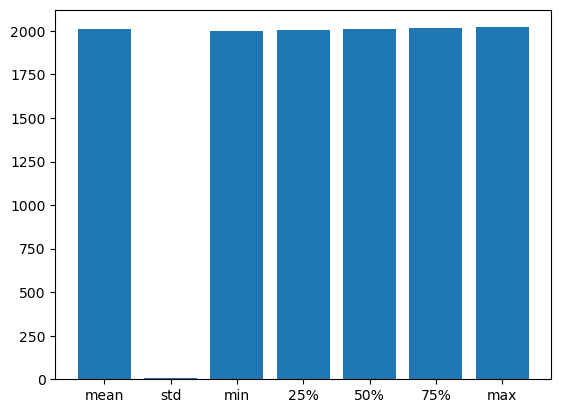

In [51]:
plt.figure()
plt.bar(raw_df.describe()['list_year'].index[1:], raw_df.describe()['list_year'].values[1:])
plt.show()

In [52]:
raw_df.describe()['list_year'].values[1:]

array([2010.77403491,    6.54069454, 2001.        , 2004.        ,
       2011.        , 2017.        , 2021.        ])